Scaler# *CS5227 - Data Mining*
## *Assignment 02 - Time Series Forecasting*
### *_Group 09_*
#### Kokularaj B.(239329T)
#### Banujan C. (239306V)
#### Ramsan M.M.M. (239348B)
#### Lakmal D.K.D.L. (229415U)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


In [2]:
#Import libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from rich.progress import Progress

!pip install darts
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts import TimeSeries
from darts.dataprocessing import Pipeline
from darts.dataprocessing.transformers import Scaler, StaticCovariatesTransformer, MissingValuesFiller, InvertibleMapper
from darts.models.filtering.moving_average_filter import MovingAverageFilter

from sklearn.preprocessing import OrdinalEncoder,RobustScaler,MinMaxScaler

from darts.models import LightGBMModel
import gc

  Obtaining dependency information for darts from https://files.pythonhosted.org/packages/0b/29/3d09769040517fe39c2b16c3445a9d88d1290e88ba67a9a08a7071efafce/darts-0.26.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 2.0 MB/s eta 0:00:00
  Obtaining dependency information for pmdarima>=1.8.0 from https://files.pythonhosted.org/packages/ec/2b/e7d18360d56396b62781ba4616527af49244d4bed51f0780646fa3953cc8/pmdarima-2.0.4-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.4/159.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ | / done
  Obtaining dependency information for statsforecast>=1.4 from https://files.pythonhosted.org/packages/f0/c5/ed81d179271f2c5ed51eab47aff164fc4f125d695ef582902c65ac8b8a01/statsforecast-1.6.0-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
  Obtaining depend

In [3]:
#Load the dataframe
train_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/train.csv')
test_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/test.csv')
holidays_events_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv')
oil_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/oil.csv')
stores_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/stores.csv')
transactions_df = pd.read_csv('/kaggle/input/store-sales-time-series-forecasting/transactions.csv')

In [4]:
train_df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

In [5]:
train_df.dtypes

id               int64
date            object
store_nbr        int64
family          object
sales          float64
onpromotion      int64
dtype: object

In [6]:
# Find the start and end times
train_start_time = train_df['date'].min()
train_end_time = train_df['date'].max()

print('The train data set is from {} to {}'.format(train_start_time,train_end_time))

The train data set is from 2013-01-01 to 2017-08-15


Train data included from 2013-01-01 to 2017-08-31, we can noticed that last 4 month of year 2017 is not avaialble in the train dataset

Skewness of sales: 7.358757818882655


count    3.000888e+06
mean     3.577757e+02
std      1.101998e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.958473e+02
max      1.247170e+05
Name: sales, dtype: float64

/tmp/ipykernel_20/3427153950.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dataset['sales'], bins=6)


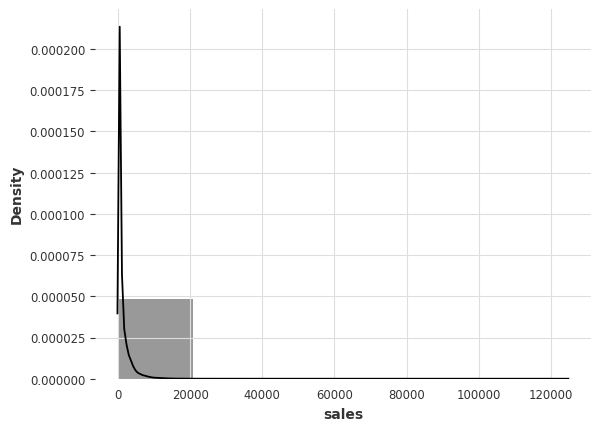

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

def check_sales_skewness(dataset):
    """
    Calculate and display the skewness of the 'sales' variable, along with its descriptive statistics.

    Parameters:
    dataset (DataFrame): The pandas DataFrame containing the 'sales' variable.
    """
    print('Skewness of sales:', dataset['sales'].skew())

    # Display descriptive statistics
    display(dataset['sales'].describe())

    # Visualize the distribution of sales
    sns.distplot(dataset['sales'], bins=6)
    plt.show()

# Checking for Train dataset
check_sales_skewness(train_df)

The sales variable in the train dataset is highly positive skewness

In [8]:
test_df.head()

id        date  store_nbr      family  onpromotion
0  3000888  2017-08-16          1  AUTOMOTIVE            0
1  3000889  2017-08-16          1   BABY CARE            0
2  3000890  2017-08-16          1      BEAUTY            2
3  3000891  2017-08-16          1   BEVERAGES           20
4  3000892  2017-08-16          1       BOOKS            0

In [9]:
# Find the start and end times
test_start_time = test_df['date'].min()
test_end_time = test_df['date'].max()

print('The test data set is from {} to {}'.format(test_start_time,test_end_time))

The test data set is from 2017-08-16 to 2017-08-31


In [10]:
dataStart=min(train_start_time,test_start_time)
dataEnd=max(test_end_time,train_end_time)
print('The train data is from {} to {}'.format(dataStart,dataEnd))

The train data is from 2013-01-01 to 2017-08-31


In [11]:
holidays_events_df.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

In [12]:
oil_df.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

In [13]:
stores_df.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

In [14]:
transactions_df.sort_values(['store_nbr','date'], inplace= True)
transactions_df.head()

date  store_nbr  transactions
1    2013-01-02          1          2111
47   2013-01-03          1          1833
93   2013-01-04          1          1863
139  2013-01-05          1          1509
185  2013-01-06          1           520

In [15]:
family_list = train_df['family'].unique()
family_list

array(['AUTOMOTIVE', 'BABY CARE', 'BEAUTY', 'BEVERAGES', 'BOOKS',
       'BREAD/BAKERY', 'CELEBRATION', 'CLEANING', 'DAIRY', 'DELI', 'EGGS',
       'FROZEN FOODS', 'GROCERY I', 'GROCERY II', 'HARDWARE',
       'HOME AND KITCHEN I', 'HOME AND KITCHEN II', 'HOME APPLIANCES',
       'HOME CARE', 'LADIESWEAR', 'LAWN AND GARDEN', 'LINGERIE',
       'LIQUOR,WINE,BEER', 'MAGAZINES', 'MEATS', 'PERSONAL CARE',
       'PET SUPPLIES', 'PLAYERS AND ELECTRONICS', 'POULTRY',
       'PREPARED FOODS', 'PRODUCE', 'SCHOOL AND OFFICE SUPPLIES',
       'SEAFOOD'], dtype=object)

In [16]:
#Merge the train_df and store_df on "store_nbr"
train_stor_megred = pd.merge(train_df, stores_df, on ='store_nbr')
train_stor_megred = train_stor_megred.sort_values(["store_nbr","family","date"])
train_stor_megred = train_stor_megred.astype({"store_nbr":'str', "family":'str', "city":'str',
                          "state":'str', "type":'str', "cluster":'int'})

In [17]:
train_stor_megred.head()

id        date store_nbr      family  sales  onpromotion   city  \
0       0  2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
33   1782  2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
66   3564  2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
99   5346  2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
132  7128  2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   

         state type  cluster  
0    Pichincha    D       13  
33   Pichincha    D       13  
66   Pichincha    D       13  
99   Pichincha    D       13  
132  Pichincha    D       13

#### Check the missing value

In [18]:
train_stor_megred.isna().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
city           0
state          0
type           0
cluster        0
dtype: int64

* No Missing value

### Sales Data Analysis over Time

In [19]:
import plotly.express as px
import pandas as pd

def plot_avg_sales_over_time_interactive(df):
    """
    Calculate and plot average sales over daily, weekly, and monthly time periods,
    with different colors for each year, using Plotly for interactivity.

    Parameters:
    df (DataFrame): The pandas DataFrame with a 'date' column and 'sales' column.
    """
    # Ensure 'date' is a datetime column
    df['date'] = pd.to_datetime(df['date'])
    
    # Adding a 'year' column for coloring
    df['year'] = df['date'].dt.year.astype(str)  # Convert year to string for better color handling

    # Isolating the 'sales' column for resampling
    sales_data = df[['date', 'sales', 'year']]

    # Calculating Average Sales
    daily_avg_sales = sales_data.resample('D', on='date').mean().reset_index()
    weekly_avg_sales = sales_data.resample('W', on='date').mean().reset_index()
    monthly_avg_sales = sales_data.resample('M', on='date').mean().reset_index()

    # Assigning the 'year' to the resampled data
    daily_avg_sales['year'] = daily_avg_sales['date'].dt.year.astype(str)
    weekly_avg_sales['year'] = weekly_avg_sales['date'].dt.year.astype(str)
    monthly_avg_sales['year'] = monthly_avg_sales['date'].dt.year.astype(str)
    
    # Plotting Average Sales Over Time
    data_frames = [daily_avg_sales, weekly_avg_sales, monthly_avg_sales]
    titles = ['Daily Average Sales', 'Weekly Average Sales', 'Monthly Average Sales']

    for data, title in zip(data_frames, titles):
        fig = px.line(data_frame=data, x='date', y='sales', color='year',
                      title=title, labels={'sales': 'Average Sales', 'date': 'Date'})
        fig.update_traces(mode='lines+markers',
                          hovertemplate='Sales: %{y:.2f}<extra></extra>')
        fig.update_layout(hovermode='x unified')
        fig.show()

# Plot chart
plot_avg_sales_over_time_interactive(train_stor_megred)

In [20]:
import plotly.graph_objects as go

def plot_avg_sales_by_day_of_week_plotly(df):
    """
    Analyze and plot the average sales by day of the week using Plotly,
    with horizontal data labels and custom hover text.

    Parameters:
    df (DataFrame): The pandas DataFrame with a 'date' column and 'sales' column.
    """
    # Ensure 'date' is a datetime column
    df['date'] = pd.to_datetime(df['date'])
    df['day_of_week'] = df['date'].dt.dayofweek

    # Analyzing Average Sales by Day of the Week
    weekly_pattern = df.groupby('day_of_week')['sales'].mean()

    # Creating day names for the x-axis
    days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

    # Plotting
    fig = go.Figure(go.Bar(
        x=days, 
        y=weekly_pattern,
        text=weekly_pattern.round(2),
        textposition='outside',
        hovertemplate='Sales: %{y:.2f}<extra></extra>',
        marker_color=px.colors.qualitative.Plotly
    ))
    
    fig.update_layout(
        title='Average Sales by Day of the Week',
        xaxis_title='Day of the Week',
        yaxis_title='Average Sales',
        yaxis=dict(tickformat=".2f")
    )

    fig.update_traces(texttemplate='%{text:.2f}')
    fig.show()

# Example usage
plot_avg_sales_by_day_of_week_plotly(train_stor_megred)

1. From year 2013 to 2017 sales are increasing which indicate that there is a Trend variable.
2. Based on Average sales by weekly or monthly chart we can see at the end of the year sales are at peak state, which indicate that there is a seasonality variable
3. Average sales by monthly chart clearly display a zero sales at the begining of the year. Reason for this could be Favorita Supermarkets chain were closed at first few days at the begining of the year.
4. Based on the Average sales by day of the week chart, we can see weekend have more sales than other days and Thursday sales are smaller than rest of the days. 

In [21]:
import numpy as np

def plot_sales_vs_promotion_plotly(df):
    """
    Analyze and plot the relationship between total sales and promotional items,
    including the correlation coefficient, using Plotly.

    Parameters:
    df (DataFrame): The pandas DataFrame with 'date', 'sales', and 'onpromotion' columns.
    """
    # Aggregating Sales and Promotional Data by Date
    promo_sales_analysis = df.groupby(['date'])[['sales', 'onpromotion']].sum().reset_index()

    # Correlation Between Sales and Promotional Items
    correlation = promo_sales_analysis[['sales', 'onpromotion']].corr().iloc[0, 1]
    print('Correlation between Total Sales & Promotional Items:', np.round(correlation, 4), '\n')

    # Visualizing the Relationship
    fig = px.scatter(promo_sales_analysis, x='onpromotion', y='sales', trendline='ols',
                     labels={'onpromotion': 'Total Items on Promotion', 'sales': 'Total Sales'},
                     title='Total Sales vs. Total Items On-promotion')
    # Adding correlation coefficient to the plot
    fig.add_annotation(x=max(promo_sales_analysis['onpromotion']), y=max(promo_sales_analysis['sales']),
                       text=f'Correlation: {correlation:.4f}',
                       showarrow=False, yshift=10)

    fig.update_traces(marker=dict(color='blue', opacity=0.7),
                      hovertemplate="Promotion: %{x}<br>Sales: %{y}")

    fig.update_layout(hovermode='closest')
    fig.show()

# Example usage
plot_sales_vs_promotion_plotly(train_stor_megred)

Correlation between Total Sales & Promotional Items: 0.5749 



onpromotion column indicate that the total number of items in a product family that were being promoted and sold at a store at a given date. According to above scatterplot we can see there is a relationship betwen Total sold items on promotions and Total sales. Also, 0.5749 corrleation coefficient indicate that there is a moderate relationship between these two varaibles.

### Average sales by Product Family

In [22]:
import plotly.express as px
import pandas as pd

def plot_avg_sales_by_family_plotly(df):
    """
    Plot a bar chart showing average sales by product family using Plotly, sorted from lower to higher,
    with sales values rounded to two decimals. The values are displayed as data labels and in hover information.

    Parameters:
    df (DataFrame): The pandas DataFrame with 'family' and 'sales' columns.
    """
    # Grouping by 'family' and calculating mean sales, then rounding to two decimal places
    avg_sales_by_family = df.groupby('family')['sales'].mean().sort_values(ascending=True).round(2).reset_index()

    # Creating the bar chart with different colors for each bar and displaying the rounded sales as labels
    fig = px.bar(avg_sales_by_family, x='sales', y='family', orientation='h',
                 color='sales', 
                 color_continuous_scale=px.colors.sequential.Viridis,
                 labels={'sales': 'Avg. Sales', 'family': 'Family Product'},
                 title='Avg. Sales by Family Product',
                 text='sales')

    # Update layout and add hover data
    fig.update_layout(xaxis_title='Avg. Sales', yaxis_title='Family Product', height=600)
    fig.update_traces(texttemplate='%{text}', textposition='outside',
                      textfont_size=14,  # Increase font size here
                      hovertemplate='<b>Family:</b> %{y}<br><b>Avg. Sales:</b> %{text}')
    
    fig.show()

    # Identifying top 5 and bottom 5 products based on sales
    top_families = avg_sales_by_family.tail(5)['family'].tolist()
    bottom_families = avg_sales_by_family.head(5)['family'].tolist()

    print('The best family products sell are: ', top_families)
    print('\nThe worst family products sell are: ', bottom_families)

# Example usage
plot_avg_sales_by_family_plotly(train_stor_megred)

The best family products sell are:  ['DAIRY', 'CLEANING', 'PRODUCE', 'BEVERAGES', 'GROCERY I']

The worst family products sell are:  ['BOOKS', 'BABY CARE', 'HOME APPLIANCES', 'HARDWARE', 'MAGAZINES']


### Average sales by Store

In [23]:
def plot_avg_sales_by_store(df):
    """
    Plot a bar chart showing average sales by store number using Plotly,
    and print the best and worst selling stores.

    Parameters:
    df (DataFrame): The pandas DataFrame with 'store_nbr' and 'sales' columns.
    """
    # Grouping by 'store_nbr' and calculating mean sales, then rounding to two decimal places
    avg_sales_by_store = df.groupby('store_nbr')['sales'].mean().sort_values(ascending=False).round(2).reset_index()

    # Creating the bar chart with different colors for each bar
    fig = px.bar(avg_sales_by_store, x='store_nbr', y='sales',
                 color='sales', 
                 color_continuous_scale=px.colors.sequential.Viridis,
                 labels={'store_nbr': 'Store No.', 'sales': 'Avg. Sales'},
                 title='Avg. Sales by Store No.',
                 text='sales')

    # Update layout and add hover data
    fig.update_layout(xaxis_title='Store No.', yaxis_title='Avg. Sales', height=600)
    fig.update_traces(texttemplate='%{text}', textposition='outside',
                      textfont_size=14,  # Increase font size here
                      hovertemplate='<b>Store No.:</b> %{x}<br><b>Avg. Sales:</b> %{text}')

    fig.show()

    # Identifying top 5 and bottom 5 stores based on sales
    top_stores = avg_sales_by_store.head(5)['store_nbr'].tolist()
    bottom_stores = avg_sales_by_store.tail(5)['store_nbr'].tolist()

    print('The best stores No. sell are: ', top_stores)
    print('\nThe worst stores No. sell are: ', bottom_stores)

# Example usage
plot_avg_sales_by_store(train_stor_megred)

The best stores No. sell are:  ['44', '45', '47', '3', '49']

The worst stores No. sell are:  ['35', '30', '32', '22', '52']


### Average Sales by National Holidays

In [24]:
# Cleaning the holidays_events_df DataFrame
cleaned_holidays = holidays_events_df[(holidays_events_df.transferred == False) & 
                                      (holidays_events_df.type != 'Work Day')]
cleaned_holidays = cleaned_holidays.drop_duplicates(subset='date')

In [25]:
import plotly.graph_objects as go

avg_sales_df = train_stor_megred.groupby('date')['sales'].mean().to_frame()

# Convert 'date' column in avg_sales_df to datetime if it's not already
avg_sales_df.reset_index(inplace=True)
avg_sales_df['date'] = pd.to_datetime(avg_sales_df['date'])

# Convert 'date' column in cleaned_holidays to datetime if it's not already
cleaned_holidays['date'] = pd.to_datetime(cleaned_holidays['date'])

avg_sales_df = train_stor_megred.groupby('date')['sales'].mean().to_frame()

# National and Regional Holidays
national_regional_holidays = cleaned_holidays[cleaned_holidays['locale'] != 'Local']
nr_holidays_avg_sales = avg_sales_df.reset_index().merge(national_regional_holidays, on='date', how='left')

# Creating a scatter plot for National and Regional Holidays
fig = go.Figure()
fig.add_trace(go.Scatter(x=avg_sales_df.index, y=avg_sales_df['sales'], mode='lines', name='Average Sales'))
fig.add_trace(go.Scatter(x=nr_holidays_avg_sales['date'], y=nr_holidays_avg_sales['sales'], mode='markers', name='National/Regional Holiday', marker=dict(color='red')))
fig.update_layout(title='Average Sales At National and Regional Holidays Only', xaxis_title='Date', yaxis_title='Avg. Sales')
fig.show()

# Local Holidays
local_holidays = cleaned_holidays[cleaned_holidays['locale'] == 'Local']
local_holidays_avg_sales = avg_sales_df.reset_index().merge(local_holidays, on='date', how='left')

# Creating a scatter plot for Local Holidays
fig = go.Figure()
fig.add_trace(go.Scatter(x=avg_sales_df.index, y=avg_sales_df['sales'], mode='lines', name='Average Sales'))
fig.add_trace(go.Scatter(x=local_holidays_avg_sales['date'], y=local_holidays_avg_sales['sales'], mode='markers', name='Local Holiday', marker=dict(color='green')))
fig.update_layout(title='Average Sales At Local Holidays', xaxis_title='Date', yaxis_title='Avg. Sales')
fig.show()

Certainly, there is a distinction among these three types of holidays. Local holidays do not have a notable effect on sales compared to regular days, whereas sales during national/regional holidays have a more pronounced impact on sales when compared to other days.

### Averages Sales vs Oil Price

In [26]:
import plotly.graph_objects as go
import pandas as pd

def plot_oil_prices(oil_df):
    """
    Plot a line chart of oil prices over time using Plotly.

    Parameters:
    oil_df (DataFrame): DataFrame containing 'date' and oil price data.
    """
    # Creating a copy of oil_df
    oil_data = oil_df.copy()

    # Ensure 'date' is a datetime column
    oil_data['date'] = pd.to_datetime(oil_data['date'])
    oil_data.set_index('date', inplace=True)

    # Plotting
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=oil_data.index, y=oil_data['dcoilwtico'], mode='lines', name='Oil Price'))

    fig.update_layout(title='Oil Prices Over Time', xaxis_title='Date', yaxis_title='Oil Price', xaxis_rangeslider_visible=True)
    fig.show()

# Example usage
plot_oil_prices(oil_df)

In [27]:
oil_df.head()

date  dcoilwtico
0  2013-01-01         NaN
1  2013-01-02       93.14
2  2013-01-03       92.97
3  2013-01-04       93.12
4  2013-01-07       93.20

Certainly, in the oil price dataset, we observe a discernible trend and seasonal pattern. Each year, typically around the middle of the year (June and July), oil prices reach their highest point. Moreover, there is a noticeable decline in oil prices during the period from 2013 to 2015 compared to the period from 2015 to 2017.

In [28]:
import pandas as pd
import plotly.graph_objects as go
import numpy as np

def plot_sales_vs_oil_price(train_stor_megred, oil_df):
    """
    Plot average sales vs. oil price using Plotly and calculate the correlation.

    Parameters:
    train_stor_megred (DataFrame): DataFrame with 'date' and 'sales'.
    oil_df (DataFrame): DataFrame containing 'date' and oil price data.
    """
    # Creating copies to avoid modifying the original DataFrames
    train_data = train_stor_megred.copy()
    oil_data = oil_df.copy()

    # Ensure 'date' columns are datetime objects
    train_data['date'] = pd.to_datetime(train_data['date'])
    oil_data['date'] = pd.to_datetime(oil_data['date'])

    # Merging and Filling NaNs
    merged_data = pd.merge(left=train_data, right=oil_data, left_on='date', right_on='date', how='left')
    merged_data.rename({'dcoilwtico': 'oil_price'}, axis=1, inplace=True)
    merged_data['oil_price'] = merged_data['oil_price'].fillna(method='ffill').fillna(method='bfill').astype('float32')

    # Grouping by oil_price
    avg_sales = merged_data.groupby(['date', 'oil_price'])['sales'].mean().reset_index()

    # Calculating Correlation
    correlation = np.round(avg_sales[['sales', 'oil_price']].corr().iloc[0, 1], 4)
    print('The correlation between average sales & oil price is:', correlation, '\n')

    # Plotting
    fig = go.Figure(data=go.Scatter(x=avg_sales['oil_price'], y=avg_sales['sales'], mode='markers',
                                    marker=dict(color='blue', size=5),
                                    line=dict(color='red', width=3)))
    fig.update_layout(title='Average Sales vs. Oil Price', xaxis_title='Oil Price', yaxis_title='Avg. Sales')
    fig.show()

# Example usage
plot_sales_vs_oil_price(train_stor_megred, oil_df)

The correlation between average sales & oil price is: -0.6241 



As expected we can see a negative corrleation between Average sales prices vs Oil price. 

When oil prices are down, it gives consumers more spending power. This is the reason behind the rise in average sales since the middle of 2015.

The chart displayed above provides a straightforward message: when oil prices are lower, we see an uptick in the average number of units sold. 

### Average Sales by Store Analysis

In [29]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

def plot_sales_by_store_characteristics(train_stor_megred, stores_df):
    """
    Plot various charts using Plotly to show average sales by store characteristics with data labels.

    Parameters:
    train_stor_megred (DataFrame): DataFrame with 'store_nbr' and 'sales'.
    stores_df (DataFrame): DataFrame containing store information.
    """
    # Creating copies to avoid modifying the original DataFrames
    train_data = train_stor_megred.copy()
    stores_data = stores_df.copy()

    # Ensuring 'store_nbr' is the same data type in both DataFrames
    train_data['store_nbr'] = train_data['store_nbr'].astype(str)
    stores_data['store_nbr'] = stores_data['store_nbr'].astype(str)

    # Grouping average sales by store number
    avg_sales = train_data.groupby('store_nbr')['sales'].mean().reset_index()

    # Merging with stores data
    stores_data_merged = pd.merge(stores_data, avg_sales, on='store_nbr', how='left')

    # Grouping by various store characteristics
    state_grouped = stores_data_merged.groupby('state')['sales'].mean().sort_values(ascending=False)
    type_grouped = stores_data_merged.groupby('type')['sales'].mean().sort_values(ascending=False)
    cluster_grouped = stores_data_merged.groupby('cluster')['sales'].mean().sort_values(ascending=False)
    city_grouped = stores_data_merged.groupby('city')['sales'].mean().sort_values(ascending=False)

    # Creating subplots
    fig = make_subplots(rows=2, cols=2, 
                        subplot_titles=('Avg. Sales by State', 'Avg. Sales by Store Type', 
                                        'Avg. Sales by Store Cluster', 'Avg. Sales by City'),
                        specs=[[{"type": "bar"}, {"type": "pie"}], 
                               [{"type": "pie"}, {"type": "bar"}]])

    # Avg. Sales by State Chart
    fig.add_trace(go.Bar(x=state_grouped.index, y=state_grouped.values, name='State',
                         text=state_grouped.values,textfont_size=14, textposition='outside', 
                         marker_color=px.colors.qualitative.Plotly), row=1, col=1)

    # Avg. Sales by Store Type
    fig.add_trace(go.Pie(labels=type_grouped.index, values=type_grouped.values, name='Type',
                         textinfo='label+percent', textposition='outside'), row=1, col=2)

    # Avg. Sales by Store Cluster
    fig.add_trace(go.Pie(labels=cluster_grouped.index, values=cluster_grouped.values, name='Cluster',
                         textinfo='label+percent', textposition='outside'), row=2, col=1)

    # Avg. Sales by City
    fig.add_trace(go.Bar(x=city_grouped.index, y=city_grouped.values, name='City',
                         text=city_grouped.values,textfont_size=14, textposition='outside', 
                         marker_color=px.colors.qualitative.T10), row=2, col=2)

    # Update layout
    fig.update_traces(textfont_size=14, hovertemplate='%{label}: %{value:.2f}')  # Formatting hover to two decimal points
    fig.update_layout(height=800, width=1500, title_text='Average Sales by Store Characteristics', showlegend=True)
    fig.update_xaxes(title_text='State', row=1, col=1)
    fig.update_xaxes(title_text='City', row=2, col=2)
    fig.update_yaxes(title_text='Avg. Sales', row=1, col=1)
    fig.update_yaxes(title_text='Avg. Sales', row=2, col=2)
    
    fig.show()

# Example usage
plot_sales_by_store_characteristics(train_stor_megred, stores_df)

*     The top-performing states in terms of sales are Pichincha, Tungurahua, and Loja, while the least performing ones are Cotopaxi, Manabi, and Pastaza.

*     Among cities, Quito, Cayambe, and Ambato lead in sales, whereas Playas, Manta, and Puyo rank the lowest.

*     Regarding store clusters, clusters 5, 14, 8, and 11 are the most successful, while clusters 7, 3, 15, and 16 perform the poorest.

*     The order of store types with the highest impact on Favorita Supermarkets sales is: A -> D -> B -> E -> C.

All of these variables have a significant influence on Favorita Supermarkets' sales, so they will be incorporated into our training process.

### Total Sales vs Tranctions

The "Sales" data represents the overall sales of a product category within a specific store on a specific date. It's important to note that fractional values are feasible because products can be sold in partial quantities (for example, 1.5 kg of cheese rather than a whole bag of chips).

For this reason, transactions will serve as a significant factor in our model. In the upcoming sections, we'll create additional features by analyzing transaction data.

In [30]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def plot_sales_vs_transactions(train_stor_megred, transactions_df):
    """
    Plot charts using Plotly to show the relationship between total sales and transactions,
    and transactions over time by store number.

    Parameters:
    train_stor_megred (DataFrame): DataFrame with 'date', 'store_nbr' and 'sales'.
    transactions_df (DataFrame): DataFrame containing 'date', 'store_nbr' and 'transactions'.
    """
    # Creating copies to avoid modifying the original DataFrames
    train_data = train_stor_megred.copy()
    transactions_data = transactions_df.copy()

    # Ensure 'date' columns are datetime objects
    train_data['date'] = pd.to_datetime(train_data['date'])
    transactions_data['date'] = pd.to_datetime(transactions_data['date'])

    # Ensure 'store_nbr' columns are of the same data type (int)
    train_data['store_nbr'] = train_data['store_nbr'].astype(int)
    transactions_data['store_nbr'] = transactions_data['store_nbr'].astype(int)

    # Grouping by date and store number
    grouped_sales = train_data.groupby(['date', 'store_nbr'])['sales'].sum().reset_index()

    # Merging with transactions data
    merged_data = pd.merge(grouped_sales, transactions_data, on=['date', 'store_nbr'], how='left')

    # Calculating Correlation
    correlation = np.round(merged_data[['sales', 'transactions']].corr().iloc[0, 1], 4)
    print('The correlation between total sales & transactions is:', correlation, '\n')

    # Plotting Total Sales vs Transactions
    fig = px.scatter(merged_data, x='transactions', y='sales', trendline='ols',
                     labels={'transactions': 'Transactions', 'sales': 'Total Sales'},
                     title='Total Sales vs Transactions')
    fig.update_layout(xaxis_title='Transactions', yaxis_title='Total Sales')
    fig.show()

    # Plotting Transactions Over Time by Store Number
    fig_time = px.line(merged_data, x='date', y='transactions', color='store_nbr',
                       labels={'transactions': 'Transactions', 'date': 'Date', 'store_nbr': 'Store Number'},
                       title='Transactions Over Time by Store Number')
    fig_time.update_layout(xaxis_title='Date', yaxis_title='Transactions')
    fig_time.show()

# Example usage
plot_sales_vs_transactions(train_stor_megred, transactions_df)

The correlation between total sales & transactions is: 0.8374 



*     A consistent trend emerges in transaction data, with all months showing similarity except for December between 2013 and 2017.

*     It's notable that store sales consistently experienced growth towards the end of each year.

*     We'll also incorporate transaction data into our training process.

In [31]:
train_stor_megred.head()

id       date store_nbr      family  sales  onpromotion   city  \
0       0 2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
33   1782 2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
66   3564 2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
99   5346 2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
132  7128 2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   

         state type  cluster  year  day_of_week  
0    Pichincha    D       13  2013            1  
33   Pichincha    D       13  2013            2  
66   Pichincha    D       13  2013            3  
99   Pichincha    D       13  2013            4  
132  Pichincha    D       13  2013            5

In [32]:
train_stor_megred = train_stor_megred.drop(['year', 'day_of_week'], axis=1)
train_stor_megred.head()

id       date store_nbr      family  sales  onpromotion   city  \
0       0 2013-01-01         1  AUTOMOTIVE    0.0            0  Quito   
33   1782 2013-01-02         1  AUTOMOTIVE    2.0            0  Quito   
66   3564 2013-01-03         1  AUTOMOTIVE    3.0            0  Quito   
99   5346 2013-01-04         1  AUTOMOTIVE    3.0            0  Quito   
132  7128 2013-01-05         1  AUTOMOTIVE    5.0            0  Quito   

         state type  cluster  
0    Pichincha    D       13  
33   Pichincha    D       13  
66   Pichincha    D       13  
99   Pichincha    D       13  
132  Pichincha    D       13

#### Create a time series 

In [33]:
family_timeSeries_dict = {}

for family in tqdm(family_list,disable=True):
    family_df = train_stor_megred.loc[train_stor_megred['family'] == family]

    lists_family_TS = TimeSeries.from_group_dataframe(
                                family_df,
                                time_col="date",
                                group_cols=["store_nbr","family"], # columns for grouping time series
                                static_cols=["city","state","type","cluster"], # static covariates
                                value_cols="sales", # target
                                fill_missing_dates=True, # filling missing dates, remember Dec 25th
                                freq='D' # days
                                )
    for ts in lists_family_TS:
            ts = ts.astype(np.float32)
    lists_family_TS = sorted(lists_family_TS, key=lambda ts: int(ts.static_covariates_values()[0,0]))
    
    family_timeSeries_dict[family] = lists_family_TS

In the above part a dictionary of time series is created for each product family. This involves segmenting the sales data by product family and store number, and then converting these segments into individual time series. 

Each time series represents the sales trend of a specific product family in a specific store. 

Additional store information like city, state, type, and cluster are included as static features, providing contextual data for each time series. 

This granular breakdown by product family and store allows for detailed analysis and forecasting at multiple levels.

### Create TimeSeries with index time_index

In [34]:
train_test_time_period = pd.date_range(start=dataStart, end=dataEnd, freq='D')

year = datetime_attribute_timeseries(time_index = train_test_time_period, attribute='year')
month = datetime_attribute_timeseries(time_index= train_test_time_period, attribute='month')
day = datetime_attribute_timeseries(time_index = train_test_time_period, attribute='day')
dayofyear = datetime_attribute_timeseries(time_index = train_test_time_period, attribute = 'dayofyear')
weekday = datetime_attribute_timeseries(time_index = train_test_time_period , attribute='dayofweek')
weekofyear = datetime_attribute_timeseries(time_index = train_test_time_period, attribute='weekofyear')
timesteps = TimeSeries.from_times_and_values(times = train_test_time_period,
                                            values = np.arange(len(train_test_time_period)),
                                            columns= ['linear_increase'])

time_cov = year.stack(month).stack(day).stack(dayofyear).stack(weekday).stack(weekofyear).stack(timesteps)
time_cov = time_cov.astype(np.float32)

Then we creates additional time series based on various date attributes like year, month, day, day of the week, and week of the year. These time series capture the temporal patterns in the data, which are essential for understanding seasonality and other time-related trends in sales. 

By stacking these time series together, a comprehensive temporal feature set is constructed, which can be used alongside sales data to improve the accuracy of forecasting models.

##### Create pipeline and feature transformation

Next, we focus on preprocessing and transforming the data for our time series forecasting model. This is done to enhance the model's ability to capture and learn from patterns in the data more effectively.

In [35]:
family_pipeline_dict = {}
family_TS_transformed_dict = {}

for key in tqdm(family_timeSeries_dict):
    train_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fiiling_NA")
    static_cov_transformer = StaticCovariatesTransformer(verbose=False, transformer_cat = OrdinalEncoder(), name="Encoder",n_jobs=-1)
    log_transformer = InvertibleMapper(np.log1p, np.expm1, verbose=False, n_jobs=-1, name="Log-Transform")   
    train_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler", scaler=MinMaxScaler())

    train_pipeline = Pipeline([train_filler,
                             static_cov_transformer,
                             log_transformer,
                             train_scaler])

    training_transformed = train_pipeline.fit_transform(family_timeSeries_dict[key])
    family_pipeline_dict[key] = train_pipeline
    family_TS_transformed_dict[key] = training_transformed

100%|██████████| 33/33 [00:59<00:00,  1.82s/it]


We create a dictionary of pipelines, family_pipeline_dict, and another for transformed time series, family_TS_transformed_dict. For each product family in our dataset:

*     Missing Values Handling: We use a **MissingValuesFiller** to fill any missing values in our time series data. This ensures our model has a complete dataset to learn from.
*     Static Covariates Transformation: The **StaticCovariatesTransformer** applies an OrdinalEncoder to static (non-temporal) categorical data like city, state, type, and cluster. This encoding is crucial for incorporating categorical information into our model.
*     Log Transformation: The **log_transformer** applies a logarithmic transformation (using np.log1p) to our sales data, helping stabilize variance and manage extreme values, which are common in sales data.
*     Scaling: We then scale our data using a **Scaler** with a RobustScaler to reduce the influence of outliers.
*     Pipeline Creation: These preprocessing steps are combined into a pipeline for each product family, ensuring consistent data processing.
*     Transformation and Storage: We then apply this pipeline to transform our family-specific time series data and store both the pipeline and the transformed data in their respective dictionaries.

#### Create time series for oil

In [36]:
oil_timeSeries = TimeSeries.from_dataframe(oil_df, 
                                time_col = 'date', 
                                value_cols = ['dcoilwtico'],
                                freq = 'D')

oil_timeSeries = oil_timeSeries.astype(np.float32)

# Transform
oil_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
oil_scaler = Scaler(verbose=False, n_jobs=-1, name="Scaler", scaler=MinMaxScaler())
oil_pipeline = Pipeline([
    oil_filler, 
    oil_scaler
])
oil_transformed = oil_pipeline.fit_transform(oil_timeSeries)

# Moving Averages for Oil Price
oil_moving_average_7 = MovingAverageFilter(window=7)
oil_moving_average_28 = MovingAverageFilter(window=28)

oil_moving_averages = []
ma_7 = oil_moving_average_7.filter(oil_transformed).astype(np.float32)
ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new='oil_ma_7')
ma_28 = oil_moving_average_28.filter(oil_transformed).astype(np.float32)
ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new='oil_ma_28')
oil_moving_averages = ma_7.stack(ma_28)

Considering the impact of oil prices on Ecuador's economy, we include oil price data in our analysis:

**Oil Time Series Creation**: We convert the oil_df DataFrame into a time series object, oil_timeSeries, specifying 'date' as the time column and 'dcoilwtico' for oil prices.

**Data Transformation:**

*     **A MissingValuesFiller** handles any missing values in the oil price data.
*     A **Scaler** (with RobustScaler) normalizes the oil prices.
*     These steps are combined into an oil_pipeline, which is then applied to transform the oil time series data, resulting in oil_transformed.

**Moving Averages**: We calculate **two moving averages (7-day and 28-day)** for the oil prices, offering smoothed versions of the original series. Moving averages help capture trends and reduce noise, making them valuable for forecasting.

**Combining Averages**: The 7-day and 28-day moving averages are combined into a single time series, oil_moving_averages, and are renamed for clarity

By incorporating oil prices and their moving averages, we add an important external factor to our analysis, recognizing its potential influence on sales patterns across different stores and product families. This comprehensive preprocessing and transformation approach aims to enhance the predictive power of our forecasting models.

#### Create Holiday Time Series

In this section of the code, we are processing holiday data to integrate it into our time series forecasting model. 

This process is crucial because holidays can significantly impact sales patterns, and including this information can enhance the model's accuracy.

In [37]:
#Create list of Holidays
list_of_holiday = []

for i in range(0,len(stores_df)):        
        df_holiday_dummies = pd.DataFrame(columns=['date'])
        df_holiday_dummies["date"] = holidays_events_df["date"]

        df_holiday_dummies["national_holiday"] = np.where(((holidays_events_df["type"] == "Holiday") & (holidays_events_df["locale"] == "National")), 1, 0)

        df_holiday_dummies["earthquake_relief"] = np.where(holidays_events_df['description'].str.contains('Terremoto Manabi'), 1, 0)

        df_holiday_dummies["christmas"] = np.where(holidays_events_df['description'].str.contains('Navidad'), 1, 0)

        df_holiday_dummies["football_event"] = np.where(holidays_events_df['description'].str.contains('futbol'), 1, 0)

        df_holiday_dummies["national_event"] = np.where(((holidays_events_df["type"] == "Event") & (holidays_events_df["locale"] == "National") & (~holidays_events_df['description'].str.contains('Terremoto Manabi')) & (~holidays_events_df['description'].str.contains('futbol'))), 1, 0)

        df_holiday_dummies["work_day"] = np.where((holidays_events_df["type"] == "Work Day"), 1, 0)

        df_holiday_dummies["local_holiday"] = np.where(((holidays_events_df["type"] == "Holiday") & ((holidays_events_df["locale_name"] == stores_df['state'][i]) | (holidays_events_df["locale_name"] == stores_df['city'][i]))), 1, 0)

        list_of_holiday.append(df_holiday_dummies)

len(list_of_holiday)

54

* Initial Setup: We start by creating an empty list **list_of_holiday** to store holiday data for each store.

* Iterating Through Stores: For each store in stores_df, we create a DataFrame **df_holiday_dummies**. This DataFrame is structured to capture various types of holidays and events.

* Setting Up Holiday Indicators: We use conditions to define different holiday types (**national_holiday, earthquake_relief, christmas, football_event, national_event, work_day, local_holiday**). These are binary indicators (1 for the presence of a holiday/event type, 0 otherwise), based on the **holidays_events_df** data.

* Appending to the List: Each store's holiday DataFrame is appended to **list_of_holiday**. This results in a list of DataFrames, each representing holiday information tailored to a specific store.

In [38]:

#Remove duplicates

dup_rem_holiday = []

for i in range(0,len(list_of_holiday)):         
        df_holiday_per_store = list_of_holiday[i].set_index('date')

        df_holiday_per_store = df_holiday_per_store.loc[~(df_holiday_per_store==0).all(axis=1)]

        df_holiday_per_store = df_holiday_per_store.groupby('date').agg({'national_holiday':'max', 'earthquake_relief':'max', 
                               'christmas':'max', 'football_event':'max', 
                               'national_event':'max', 'work_day':'max', 
                               'local_holiday':'max'}).reset_index()

        dup_rem_holiday.append(df_holiday_per_store)

len(dup_rem_holiday)

54

* Duplicate Removal: We initiate another list **dup_rem_holiday** to store the processed holiday data for each store without duplicates.

* Iterating and Cleaning: For each DataFrame in **list_of_holiday**, we remove rows where all holiday indicators are zero and aggregate the data to ensure that each date has a unique entry. This is done by taking the maximum value per date for each holiday type to avoid duplicates.

* Appending Processed Data: The cleaned DataFrame for each store is then appended to **dup_rem_holiday**.

In [39]:
#Create list of holiday per store
list_of_holidays_store = []

for i in range(len(dup_rem_holiday)):
        holidays_TS = TimeSeries.from_dataframe(dup_rem_holiday[i], 
                                    time_col = 'date',
                                    fill_missing_dates=True,
                                    fillna_value=0,
                                    freq='D')
        
        dataEnd

        holidays_TS = holidays_TS.slice(pd.Timestamp(dataStart),pd.Timestamp(dataEnd))
        holidays_TS = holidays_TS.astype(np.float32)
        list_of_holidays_store.append(holidays_TS)

len(list_of_holidays_store)

54

* Converting to Time Series: We convert each store's holiday DataFrame from **dup_rem_holiday** into a time series object using **TimeSeries.from_dataframe**.

* Time Series Slicing and Formatting: We slice the time series to fit within the desired date range (dataStart to dataEnd) and convert the data type to **float32**.

* Storing Time Series: Each processed time series is stored in **list_of_holidays_store**.

In [40]:
holidays_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
holidays_scaler = Scaler(verbose=False, n_jobs=-1, name="Holiday_Scaler",scaler=MinMaxScaler())

holidays_pipeline = Pipeline([holidays_filler, holidays_scaler])
holidays_transformed = holidays_pipeline.fit_transform(list_of_holidays_store)

* Setting Up Transformation Pipeline: We create a pipeline holidays_pipeline consisting of a **MissingValuesFiller** and a **Scaler** (using RobustScaler). 
This pipeline will handle missing values and scale the data.

* Applying Transformation: The pipeline is applied to each time series in **list_of_holidays_store**, resulting in holidays_transformed, a list of transformed holiday time series for each store.

In summary, we create and process holiday-related time series data tailored to each store. This data is then transformed to be integrated into the time series forecasting model, providing crucial contextual information that can impact sales, such as national holidays, local events, and specific occasions like Christmas or football matches

In [41]:
df_combine = pd.concat([train_df, test_df], axis=0)
df_combine = df_combine.sort_values(["store_nbr","family","date"])

family_promotion_dict = {}

for family in tqdm(family_list):
    df_family = df_combine.loc[df_combine['family'] == family]

    list_of_TS_promo = TimeSeries.from_group_dataframe(
                                df_family,
                                time_col="date",
                                group_cols=["store_nbr","family"],
                                value_cols="onpromotion",
                                fill_missing_dates=True,
                                freq='D')

    for ts in list_of_TS_promo:
        ts = ts.astype(np.float32)

    family_promotion_dict[family] = list_of_TS_promo

100%|██████████| 33/33 [00:45<00:00,  1.38s/it]


The main purpose of this part is to combine and prepare data for each product family across all stores and dates. This is achieved by concatenating training and testing datasets, sorting them, and then processing the onpromotion data into a time series format suitable for further analysis and forecasting.

In above we did following; 

**Combining Data**: concatenates the training and test datasets, creating a single dataset that includes both historical and future data points. It's sorted by **store_nbr, family, and date** to ensure continuity and order in the data.

**Time Series Creation**: For each product family, it creates a time series of the **onpromotion** data. The use of **TimeSeries.from_group_dataframe** method from a time series library ensures that data is in the correct format for time series analysis, with missing dates filled and frequency set to daily.

In [42]:
promotion_transformed_dict = {}

for key in tqdm(family_promotion_dict):
    promo_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Fill NAs")
    promo_scaler = Scaler(verbose=False, n_jobs=-1, name="Promo_Scaling",scaler=MinMaxScaler())

    promo_pipeline = Pipeline([promo_filler,
                             promo_scaler])

    promotion_transformed = promo_pipeline.fit_transform(family_promotion_dict[key])

    # Moving Averages for Promotion Family Dictionaries
    promo_moving_average_7 = MovingAverageFilter(window=7)
    promo_moving_average_28 = MovingAverageFilter(window=28)

    promotion_covs = []

    for ts in promotion_transformed:
        ma_7 = promo_moving_average_7.filter(ts)
        ma_7 = TimeSeries.from_series(ma_7.pd_series())  
        ma_7 = ma_7.astype(np.float32)
        ma_7 = ma_7.with_columns_renamed(col_names=ma_7.components, col_names_new="promotion_ma_7")
        ma_28 = promo_moving_average_28.filter(ts)
        ma_28 = TimeSeries.from_series(ma_28.pd_series())  
        ma_28 = ma_28.astype(np.float32)
        ma_28 = ma_28.with_columns_renamed(col_names=ma_28.components, col_names_new="promotion_ma_28")
        promo_and_mas = ts.stack(ma_7).stack(ma_28)
        promotion_covs.append(promo_and_mas)

    promotion_transformed_dict[key] = promotion_covs

100%|██████████| 33/33 [01:31<00:00,  2.79s/it]


This part involves transforming and smoothing the promotional data time series for each product family. It applies missing value imputation, scaling, and calculates moving averages to smooth out short-term fluctuations and reveal underlying trends in the promotion data.

In above we did following;

* Data Transformation: applies a pipeline of transformations including filling missing values and scaling the data using RobustScaler to standardize the onpromotion time series.

* Moving Averages: Calculates **7-day and 28-day** moving averages for each time series. These moving averages help in smoothing out the data and are particularly useful in time series forecasting to understand and visualize trends.

In [43]:
time_cov_scaler = Scaler(verbose=False, n_jobs=-1, name="Time_Scaler",scaler=MinMaxScaler())
time_cov_train, time_cov_val = time_cov.split_before(pd.Timestamp(test_start_time))
time_cov_scaler.fit(time_cov_train)
time_cov_transformed = time_cov_scaler.transform(time_cov)


general_covariates = time_cov_transformed.stack(oil_transformed).stack(oil_moving_averages)

This section focuses on scaling the time-related covariates (like oil prices, national and local holidays, etc.) to ensure they are on a consistent scale, which is important for modeling.

In above we did following;

* Data Splitting and Scaling: splits the time covariates into training and validation sets and applies scaling using RobustScaler. This normalization step is crucial to ensure that the model is not biased towards variables with larger scales.

In [44]:
store_covariates_future = []

store_list = stores_df['store_nbr'].unique()

for store in tqdm(range(0,len(store_list))):
    stacked_covariates = holidays_transformed[store].stack(general_covariates)  
    store_covariates_future.append(stacked_covariates)

100%|██████████| 54/54 [00:00<00:00, 324.41it/s]


To generate future covariates for each store by combining transformed holiday data with general covariates (like oil prices and moving averages), creating a comprehensive set of features for forecasting.

In above we did following;

* Combining Covariates: stacks the holiday data specific to each store with the general covariates (which could include factors like oil prices). This results in a complete set of covariates for each store, encompassing both store-specific and general factors.

In [45]:
future_covariates_dict = {}

for key in tqdm(promotion_transformed_dict):
    promotion_family = promotion_transformed_dict[key]
    covariates_future = [promotion_family[i].stack(store_covariates_future[i]) for i in range(0,len(promotion_family))]
    future_covariates_dict[key] = covariates_future

100%|██████████| 33/33 [00:06<00:00,  4.91it/s]


Above secton our aim is to **compile future covariates for each product family by combining the transformed promotional data with the store-specific covariates**, creating a detailed feature set for forecasting sales for each product family.

Also we did following;

* **Covariates Integration**: It stacks the transformed promotion data of each product family with the store-specific covariates. This comprehensive approach ensures that the forecasting model has access to both general and specific factors that could influence sales predictions for different product families.

In [46]:

TS_transactions_list = TimeSeries.from_group_dataframe(
                                transactions_df,
                                time_col="date",
                                group_cols=["store_nbr"],
                                value_cols="transactions",
                                fill_missing_dates=True,
                                freq='D')

transactions_list = []

for ts in TS_transactions_list:
            series = TimeSeries.from_series(ts.pd_series())
            series = series.astype(np.float32)
            transactions_list.append(series)
            
# as the transactions dataframe have for store_nbr 24 transactions from 01-01-2013 but every store_nbr have data from 02-01-2013
transactions_list[24] = transactions_list[24].slice(start_ts=pd.Timestamp(train_start_time)+pd.Timedelta(days=1), end_ts=pd.Timestamp(train_end_time))

transactions_list_full = []
for ts in tqdm(transactions_list):
    if ts.start_time() > pd.Timestamp(train_start_time):
        end_time = (ts.start_time() - timedelta(days=1))
        delta = end_time - pd.Timestamp(train_start_time)
        zero_series = TimeSeries.from_times_and_values(
                                  times=pd.date_range(start=pd.Timestamp(train_start_time), 
                                  end=end_time, freq="D"),
                                  values=np.zeros(delta.days+1))
        ts = zero_series.append(ts)
        ts = ts.with_columns_renamed(col_names=ts.components, col_names_new="transactions")
        transactions_list_full.append(ts)

transactions_filler = MissingValuesFiller(verbose=False, n_jobs=-1, name="Filler")
transactions_scaler = Scaler(verbose=False, n_jobs=-1, name="Transaction_Scaler",scaler=MinMaxScaler())

transactions_pipeline = Pipeline([transactions_filler, transactions_scaler])
transactions_transformed = transactions_pipeline.fit_transform(transactions_list_full)

100%|██████████| 54/54 [00:00<00:00, 87.55it/s]


This section focuses on processing the transaction data into a time series format and ensuring consistency in the time range across all stores. It also scales and fills missing values in the transaction data. Here, we did following; 

**Creating Transaction Time Series**: The code generates a list of time series, TS_transactions_list, from the transactions_df. Each time series corresponds to the transaction data for a specific store.

**Adjusting Time Series**: For each store, the transaction data is converted to a float32 type and added to transactions_list. **A special case is handled for store number 24 to align its start date with the others**.

**Handling Missing Dates**: The code ensures that each time series covers the entire period from the training start date. If a time series starts later, it prepends zeros to cover the missing dates.
Transforming Data: A pipeline consisting of a MissingValuesFiller and Scaler (using RobustScaler) is applied to the transaction data, standardizing it for model input

In [47]:
pd.Timestamp(dataStart)+pd.Timedelta(days=1)

Timestamp('2013-01-02 00:00:00')

In [48]:
df_indexes=df_combine.copy()
df_indexes = df_indexes.drop(['onpromotion'], axis=1)
df_indexes = df_indexes.sort_values(by=['store_nbr', 'family'])
df_indexes.date = pd.to_datetime(df_indexes.date)
df_indexes = df_indexes.set_index('date')

This section prepares an indexed DataFrame, df_indexes, which will be used to fill in missing data points and ensure data continuity.

* Creating Timestamp: The above code calculates a timestamp that is one day after the start of the data (dataStart). This is likely used for aligning or indexing purposes in subsequent steps.

* Preparing the DataFrame: It copies df_combine, drops the **onpromotion** column, and sorts the DataFrame by **store_nbr and family**. Then, it sets the date as the index, ensuring that the DataFrame is correctly formatted for time-series operations.

In [49]:
with Progress() as progress:
    task = progress.add_task("[cyan]Processing...", total=len(family_list) * len(store_list))

    for family in tqdm(family_list,disable=True):
        for store in store_list:
            temp_df = df_indexes.iloc[np.where((df_indexes.family == family) & (df_indexes.store_nbr == store))]
            temp_df = temp_df.reindex(train_test_time_period).fillna({'id': np.nan, 'store_nbr': store, 'family': family, 'sales': np.nan})
            df_indexes_filled = pd.concat([df_indexes, temp_df])
            
            progress.update(task, advance=1)

Output()

The purpose here is to fill in any missing data points for each combination of store and product family over the entire time period of interest. This step is crucial for creating a complete and continuous dataset for time series forecasting. In above part following things were considered, 


* Progress Tracking: A **progress tracker** is set up, likely for monitoring the lengthy process of iterating through the product families and stores.

* Data Filling Loop: For each product family and store combination, the code extracts the relevant rows from **df_indexes** and reindexes them to cover the entire train and test period (train_test_time_period). Missing data points are filled with default values.

* Concatenating Data: The filled DataFrame for each family-store combination is concatenated back to **df_indexes**. This process ensures that df_indexes contains complete data across all families and stores for the entire period.

In [50]:
df_indexes_filled.head()

id  store_nbr      family  sales
2013-01-01     0.0        1.0  AUTOMOTIVE    0.0
2013-01-02  1782.0        1.0  AUTOMOTIVE    2.0
2013-01-03  3564.0        1.0  AUTOMOTIVE    3.0
2013-01-04  5346.0        1.0  AUTOMOTIVE    3.0
2013-01-05  7128.0        1.0  AUTOMOTIVE    5.0

This section is focused on finalizing the preparation of a DataFrame, df_indexes_filled, which combines all the processed data. It's about organizing and cleaning this DataFrame to ensure it is ready for use in model training and forecasting.

In [51]:
df_indexes_filled.index.name = 'date'
df_indexes_filled = df_indexes_filled.reset_index()
df_indexes_filled = df_indexes_filled.sort_values(['store_nbr','family'])  
df_indexes_filled = df_indexes_filled.drop_duplicates()   #Any duplicate entries in the DataFrame are removed
df_indexes_filled.head()

date      id  store_nbr      family  sales
0 2013-01-01     0.0        1.0  AUTOMOTIVE    0.0
1 2013-01-02  1782.0        1.0  AUTOMOTIVE    2.0
2 2013-01-03  3564.0        1.0  AUTOMOTIVE    3.0
3 2013-01-04  5346.0        1.0  AUTOMOTIVE    3.0
4 2013-01-05  7128.0        1.0  AUTOMOTIVE    5.0

Above section ensure the data is in the right format, sorted correctly, and free of duplicates.

In [52]:
df_indexes_filled.dtypes

date         datetime64[ns]
id                  float64
store_nbr           float64
family               object
sales               float64
dtype: object

In [53]:
last_train_date = pd.to_datetime(train_df.date.max())

Aobve steps are integral to preparing a comprehensive and consistent dataset for forecasting sales in the competition. The focus is on ensuring data completeness, consistency, and standardization across various features like transactions, store characteristics, and holiday events, which are all crucial factors in predicting store sales.

### LGBM predictions

In [54]:
model_params = [
    {"lags" : 63, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 7, "lags_future_covariates" : (16,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},  
    {"lags" : 31, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]},
    {"lags" : 365, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}, 
    {"lags" : 730, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}, 
    {"lags" : 1095, "lags_future_covariates" : (14,1), "lags_past_covariates" : [-16,-17,-18,-19,-20,-21,-22]}
]

#val_df_size = 0

l_train_date = last_train_date - np.timedelta64(0, 'D')
local_df_indexes = df_indexes_filled.iloc[np.where(df_indexes_filled.date > l_train_date)]

submission_kaggle_list = []    
cnt = 1

for params in tqdm(model_params,disable=True):
    LGBM_Models_Submission = {}
    display("Training...")

    # Fit Model
    print(f'Start fit model {cnt}')
    for family in tqdm(family_list):    
        sales_family = family_TS_transformed_dict[family]
        # training_data: represents the number of sales in the training sample minus the sales for the val
        training_data = [ts[:1688-0] for ts in sales_family]
        # TCN_covariates: represents the future covariates associated with the target product family
        TCN_covariates = future_covariates_dict[family]
        # train_sliced: represents the number of sales associated with the target product family.
        # slice_intersect: function that you can see used simply ensures that the components span the same time interval. 
        # In the case of different time intervals an error message will appear if we try to combine them.
        train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]


        LGBM_Model_Submission = LightGBMModel(lags = params["lags"],
                                              lags_future_covariates = params["lags_future_covariates"],
                                              lags_past_covariates = params["lags_past_covariates"],
                                              output_chunk_length=1,
                                              random_state=2022,
                                              gpu_use_dp= "false")


        LGBM_Model_Submission.fit(series=train_sliced, 
                              future_covariates=TCN_covariates,
                              # transactions_transformed: the past covariates do not need to be indexed on the target 
                              # family because there is only one global `TimeSeries` per store.
                              past_covariates=transactions_transformed)

        LGBM_Models_Submission[family] = LGBM_Model_Submission

    display("Predictions...")
    LGBM_Forecasts_Families_Submission = {}

    # Predict
    print(f'Start predict model {cnt}')
    for family in tqdm(family_list):
        sales_family = family_TS_transformed_dict[family]
        training_data = [ts[:1688] for ts in sales_family]
        LGBM_covariates = future_covariates_dict[family]
        train_sliced = [training_data[i].slice_intersect(TCN_covariates[i]) for i in range(0,len(training_data))]

        forecast_LGBM = LGBM_Models_Submission[family].predict(
                                              n = 16 ,
                                              series=train_sliced,
                                              future_covariates=LGBM_covariates,
                                              past_covariates=transactions_transformed
                                             )

        LGBM_Forecasts_Families_Submission[family] = forecast_LGBM

    # Transform Back
    print(f'Start transform Back {cnt}')
    LGBM_Forecasts_Families_back_Submission = {}

    for family in tqdm(family_list):
        LGBM_Forecasts_Families_back_Submission[family] = family_pipeline_dict[family].inverse_transform(LGBM_Forecasts_Families_Submission[family], partial=True)
    print(f'Start Prepare Submission {cnt}')
    for family in tqdm(LGBM_Forecasts_Families_back_Submission):
        for n in range(0,len(LGBM_Forecasts_Families_back_Submission[family])):
            if (family_timeSeries_dict[family][n].univariate_values()[-21:] == 0).all():
                LGBM_Forecasts_Families_back_Submission[family][n] = LGBM_Forecasts_Families_back_Submission[family][n].map(lambda x: x * 0)

    listofseries = []

    for store in tqdm(range(0,54)):
        for family in family_list:
            oneforecast = LGBM_Forecasts_Families_back_Submission[family][store].pd_dataframe()
            oneforecast.columns = ['y_pred']
            listofseries.append(oneforecast)

    df_forecasts = pd.concat(listofseries) 
    df_forecasts.reset_index(drop=True, inplace=True)

    # No Negative Forecasts
    print(f'Start No Negative Forecasts {cnt}')
    df_forecasts[df_forecasts < 0] = 0
    forecasts_kaggle = pd.concat([local_df_indexes['id'], df_forecasts.set_index(local_df_indexes.index)], axis=1)
    forecasts_kaggle = forecasts_kaggle.reset_index(drop=True)

    # Submission
    print(f'Start Submission {cnt}')
    submission_kaggle_list.append(forecasts_kaggle)
    cnt += 1
    


'Training...'

Start fit model 1


100%|██████████| 33/33 [07:54<00:00, 14.38s/it]


'Predictions...'

Start predict model 1


100%|██████████| 33/33 [00:29<00:00,  1.12it/s]


Start transform Back 1


100%|██████████| 33/33 [00:34<00:00,  1.05s/it]


Start Prepare Submission 1


100%|██████████| 54/54 [00:01<00:00, 51.94it/s]


Start No Negative Forecasts 1
Start Submission 1


'Training...'

Start fit model 2


100%|██████████| 33/33 [07:00<00:00, 12.73s/it]


'Predictions...'

Start predict model 2


100%|██████████| 33/33 [00:26<00:00,  1.26it/s]


Start transform Back 2


100%|██████████| 33/33 [00:33<00:00,  1.01s/it]


Start Prepare Submission 2


100%|██████████| 54/54 [00:02<00:00, 26.77it/s]


Start No Negative Forecasts 2
Start Submission 2


'Training...'

Start fit model 3


100%|██████████| 33/33 [06:38<00:00, 12.08s/it]


'Predictions...'

Start predict model 3


100%|██████████| 33/33 [00:28<00:00,  1.15it/s]


Start transform Back 3


100%|██████████| 33/33 [00:33<00:00,  1.02s/it]


Start Prepare Submission 3


100%|██████████| 54/54 [00:01<00:00, 53.03it/s]


Start No Negative Forecasts 3
Start Submission 3


'Training...'

Start fit model 4


100%|██████████| 33/33 [14:37<00:00, 26.58s/it]


'Predictions...'

Start predict model 4


100%|██████████| 33/33 [00:28<00:00,  1.17it/s]


Start transform Back 4


100%|██████████| 33/33 [00:33<00:00,  1.01s/it]


Start Prepare Submission 4


100%|██████████| 54/54 [00:01<00:00, 53.21it/s]


Start No Negative Forecasts 4
Start Submission 4


'Training...'

Start fit model 5


100%|██████████| 33/33 [18:57<00:00, 34.48s/it]


'Predictions...'

Start predict model 5


100%|██████████| 33/33 [00:28<00:00,  1.16it/s]


Start transform Back 5


100%|██████████| 33/33 [00:34<00:00,  1.04s/it]


Start Prepare Submission 5


100%|██████████| 54/54 [00:01<00:00, 51.83it/s]


Start No Negative Forecasts 5
Start Submission 5


'Training...'

Start fit model 6


100%|██████████| 33/33 [19:05<00:00, 34.71s/it]


'Predictions...'

Start predict model 6


100%|██████████| 33/33 [00:28<00:00,  1.16it/s]


Start transform Back 6


100%|██████████| 33/33 [00:34<00:00,  1.04s/it]


Start Prepare Submission 6


100%|██████████| 54/54 [00:01<00:00, 51.64it/s]


Start No Negative Forecasts 6
Start Submission 6


This part focuses on training a set of LightGBM models for sales forecasting, each with different configurations, and generating predictions for the Kaggle competition submission. It involves the following main steps:

    1. Model Training and Prediction: Fits multiple LightGBM models on the sales data, using various configurations of lags and covariates.
    
    2. Transforming Predictions Back to Original Scale: Applies inverse transformations to the forecasts to convert them back to their original scale.
    
    3. Handling Zero Sales Scenarios: Adjusts forecasts for stores that had zero sales in the recent past.
    
    4. Combining Forecasts for Submission: Prepares the final forecasts for each store and product family combination for submission to the Kaggle competition.

Model Parameters (model_params): Defines various configurations for the LightGBM models, including lags for the target series, future covariates, and past covariates. Each configuration is designed to capture different temporal patterns in the sales data.

Prepare for Prediction (local_df_indexes): Isolates the part of the dataset needed for generating predictions.

Training Loop (for params in model_params): Iterates over each configuration in model_params, training a LightGBM model for each product family. The models are trained using sales data (family_TS_transformed_dict), future covariates (future_covariates_dict), and past covariates (transactions_transformed).

Predicting Sales: Generates forecasts for a 16-day horizon, aligning with the test dataset's time frame.

Post-Processing Forecasts:

*     Transforming Forecasts: Applies inverse transformations to the forecasts to convert them back to the original sales scale.
*     Adjusting for Zero Sales: For stores with zero sales in the recent past, the forecasts are adjusted to zero to reflect this pattern.


Combining and Preparing Submission Data:

*     Combining Forecasts: Concatenates the forecasts for each store and product family into a single DataFrame.
*     Ensuring Non-Negative Forecasts: Ensures that all forecasted values are non-negative.
*     Preparing Submission Format: Aligns the forecasts with the id column from the local_df_indexes DataFrame for submission to the Kaggle competition.

In [55]:
submissions = submission_kaggle_list[0].copy()
submissions = submissions.rename(columns={'y_pred': 'y_pred_0'})

if len(submission_kaggle_list) > 1:
    for i in range(1, len(submission_kaggle_list)):
        y_pred = submission_kaggle_list[i]
        y_pred = y_pred.rename(columns={'y_pred': f'y_pred_{i}'})
        submissions = pd.concat([submissions, y_pred.drop(['id'], axis=1)], axis=1)

submissions['sales'] = submissions.loc[:, submissions.columns!='id'].mean(axis=1)
submissions.head()

id  y_pred_0  y_pred_1  y_pred_2  y_pred_3  y_pred_4  y_pred_5  \
0  3000888.0  3.416637  3.505120  3.325951  3.315455  4.033430  3.578675   
1  3002670.0  3.025535  2.744895  3.182012  3.531136  3.577592  3.578237   
2  3004452.0  4.150959  2.981036  4.020923  4.039156  3.762354  3.576144   
3  3006234.0  4.675098  3.662024  4.540099  4.945568  4.490325  4.698057   
4  3008016.0  1.706317  1.065222  1.440925  1.835265  1.524762  1.688387   

      sales  
0  3.529211  
1  3.273235  
2  3.755096  
3  4.501862  
4  1.543480

In [56]:
submission = submissions[['id', 'sales']]
submission = submission.sort_values('id')
submission.id = submission.id.astype('int32')
submission.head()

id        sales
0   3000888     3.529211
16  3000889     0.000000
32  3000890     4.395152
48  3000891  2286.395347
64  3000892     0.038152

In [57]:
submission.to_csv('/kaggle/working/submission.csv', index=False)